# IEOR 142 Question 4

### Load and Prepare Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils import resample
from sklearn.metrics import classification_report


### Load Datasets

In [ ]:
# load datasets
regular_season_df = pd.read_csv('nba_team_stats_00_to_21.csv')
playoffs_df = pd.read_csv('nba_team_stats_playoffs_00_to_21.csv')



### Dataset Preparation

In [ ]:

#check for missing values
regular_season_df.isnull().sum()
playoffs_df.isnull().sum()

## No missing values

teamstatspk                 0
team                        0
games_played                0
wins                        0
losses                      0
win_percentage              0
minutes                     0
points                      0
field_goals_made            0
field_goals_attempted       0
field_goal_percentage       0
three_pointers_made         0
three_pointers_attempted    0
three_point_percentage      0
free_throws_made            0
free_throw_attempted        0
free_throw_percentage       0
offensive_rebounds          0
defensive_rebounds          0
rebounds                    0
assists                     0
turnovers                   0
steals                      0
blocks                      0
blocks_attempted            0
personal_fouls              0
personal_fouls_drawn        0
plus_minus                  0
season                      0
dtype: int64

In [ ]:
#Check for duplicate rows


regular_season_df.duplicated().sum()
playoffs_df.duplicated().sum()

## No duplicated rows

0

In [ ]:
# Convert the column names to lowercase in both DataFrames


regular_season_df.columns = regular_season_df.columns.str.lower()
playoffs_df.columns = playoffs_df.columns.str.lower()

#Extract a list of unique playoff teams
playoff_teams = playoffs_df['team'].unique()

# Filter the regular season dataset to include only teams that made the playoffs
regular_season_playoffs_df = regular_season_df[regular_season_df['team'].isin(playoff_teams)]

# Merge the datasets on the "team" column and include the "win_percentage" column from playoffs_df
merged_df = regular_season_playoffs_df.merge(playoffs_df[['team', 'games_played']], on='team', how='inner')



### Select Features for LDA

In [ ]:
# Merge regular season and playoffs data based on the 'TEAM' column
merged_df = regular_season_playoffs_df.merge(playoffs_df[['team', 'games_played']], on='team', how='left')



# Define the features you want to consider for analysis

features = ['pts', 'fgm', 'fga', 'fg%', '3pm', '3pa', '3p%', 'ftm', 'dreb', 'oreb', 'dreb','reb', 'ast']


pts: 0.0785662340534791
fgm: 0.07160497051340296
fga: 0.08304557904088312
fg%: 0.0786055931045572
3pm: 0.07228376777569523
3pa: 0.08027949733965462
3p%: 0.07835672855247529
ftm: 0.08403859534325933
dreb: 0.06805867461364762
oreb: 0.07615000995095073
dreb: 0.06876209105068885
reb: 0.07458010953838684
ast: 0.08566814912291915


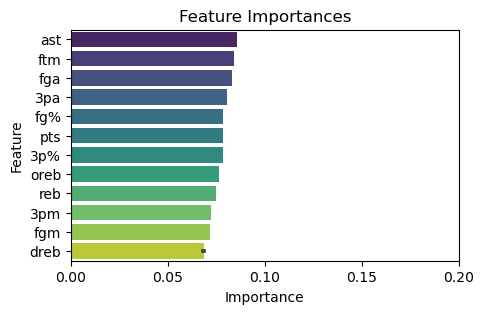

In [ ]:

# Train a Random Forest Classifier
# Assuming X_train and y_train are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(merged_df[features], merged_df['games_played'], test_size=0.2, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Print feature importances
feature_importances = rfc.feature_importances_

for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(5, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances')
plt.xticks(ticks=[0, 0.05, 0.1, 0.15, 0.2])
plt.show()




0


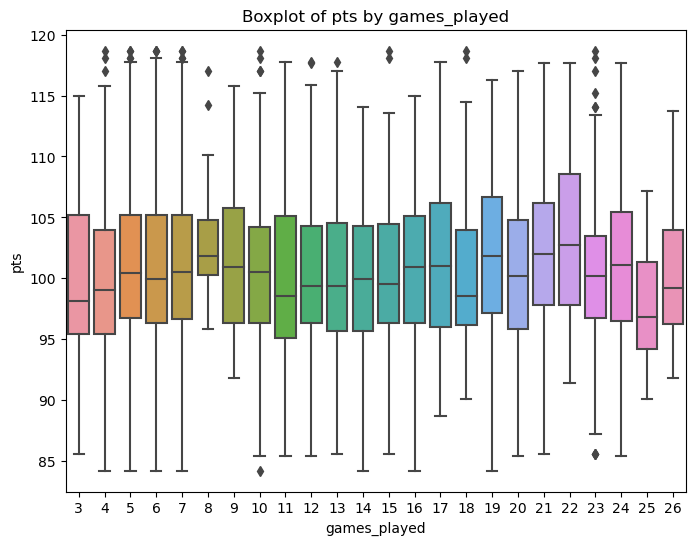

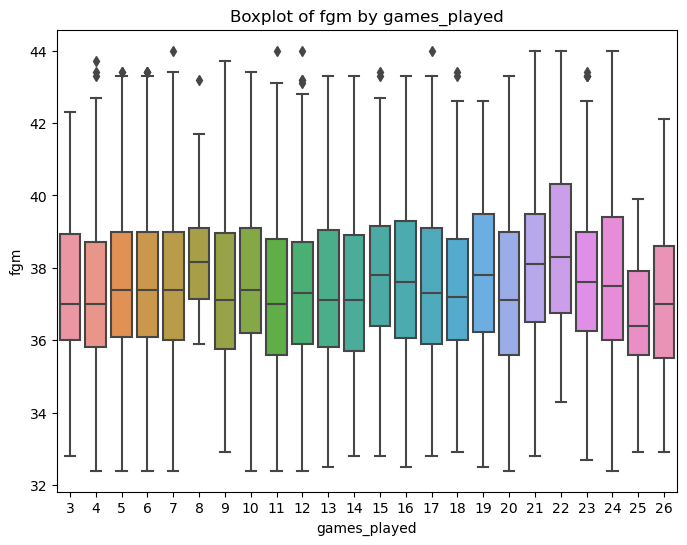

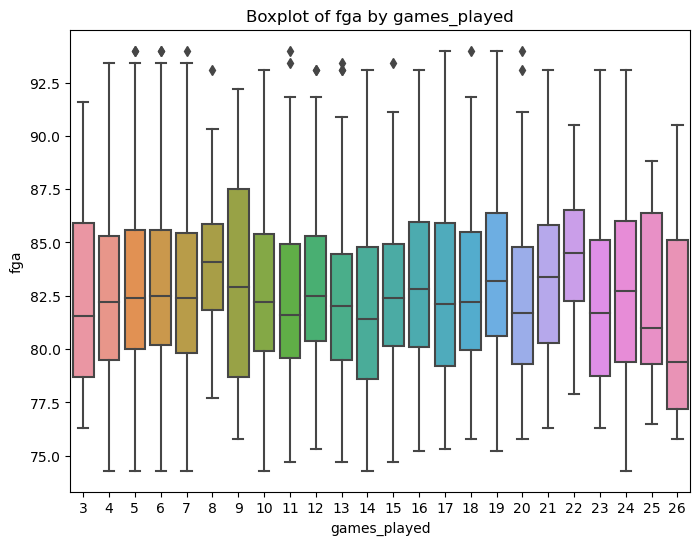

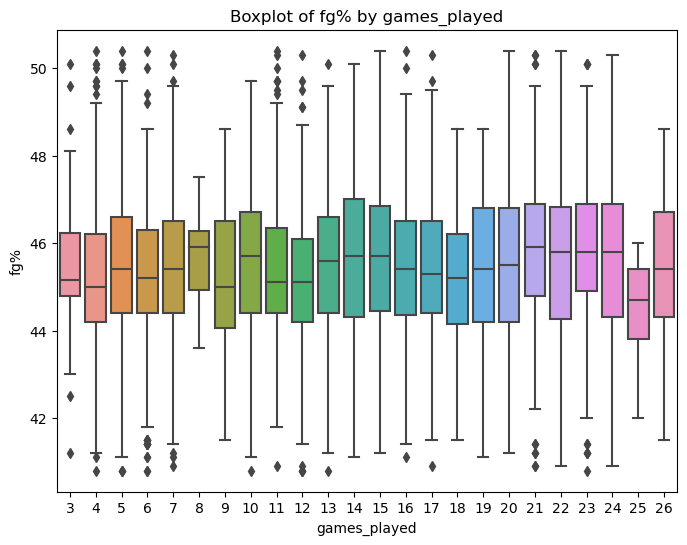

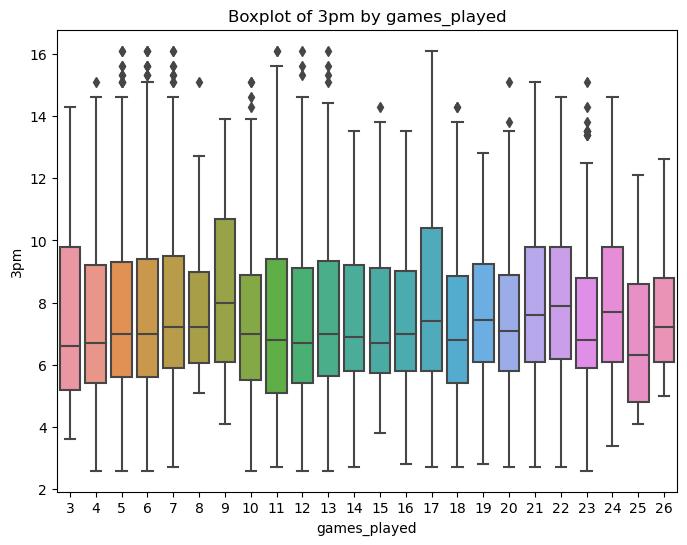

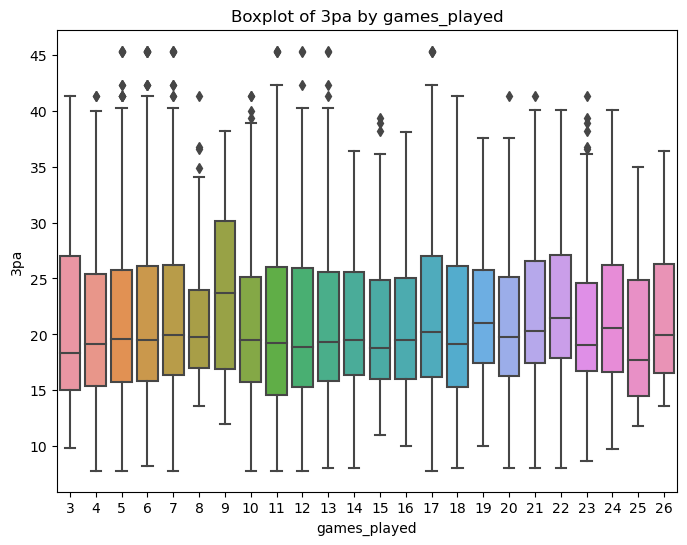

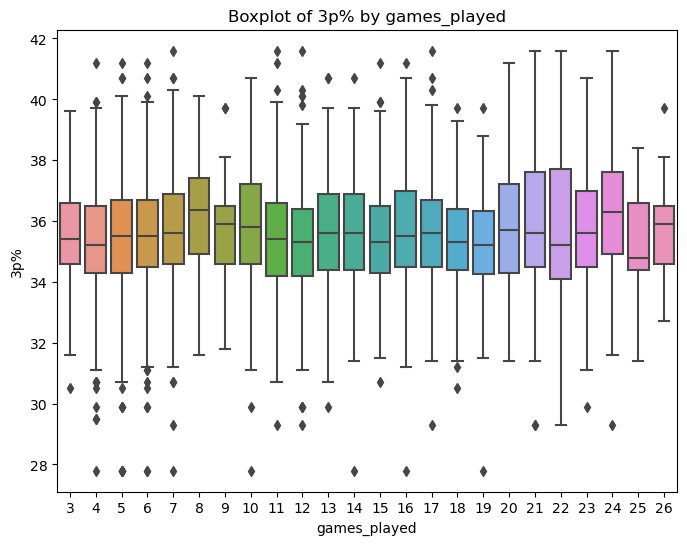

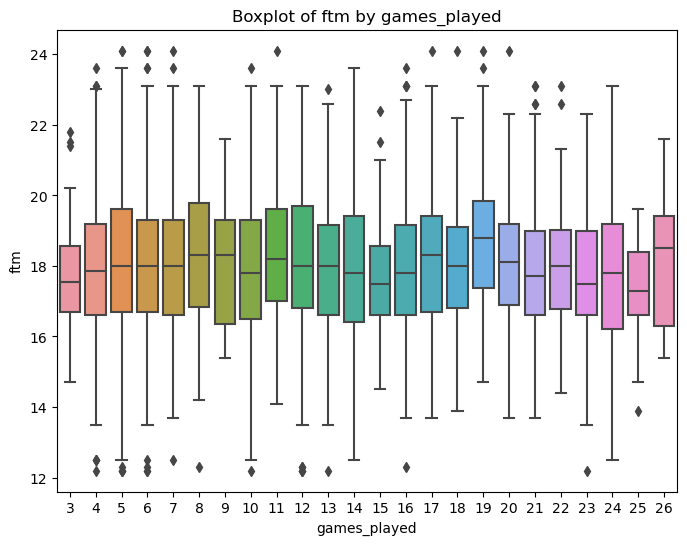

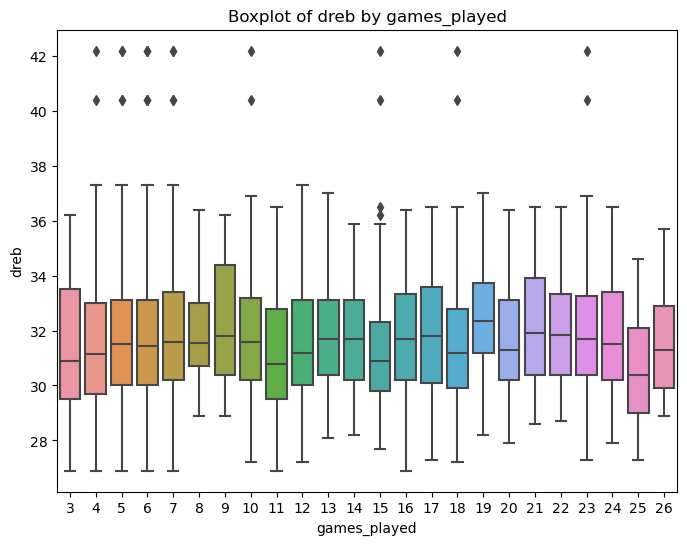

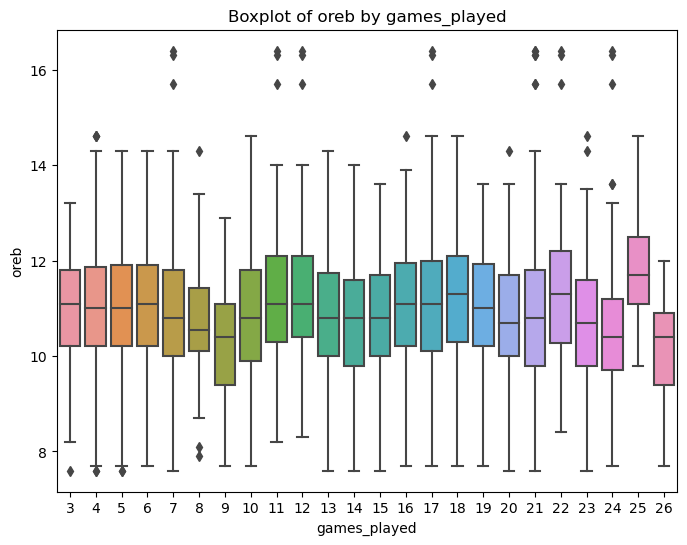

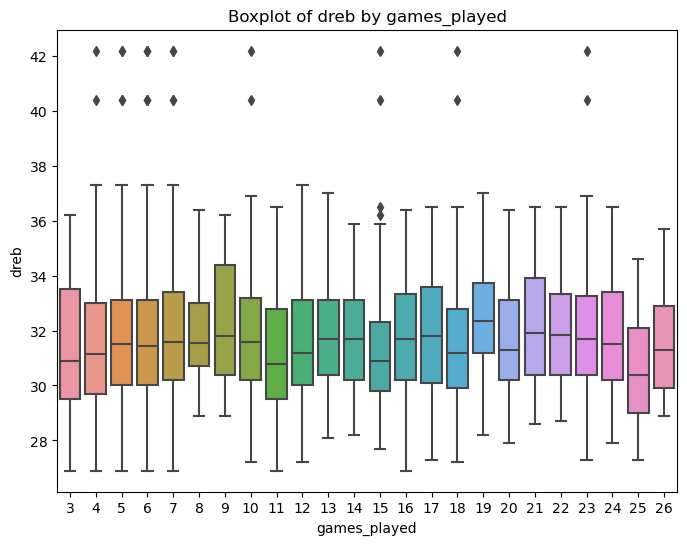

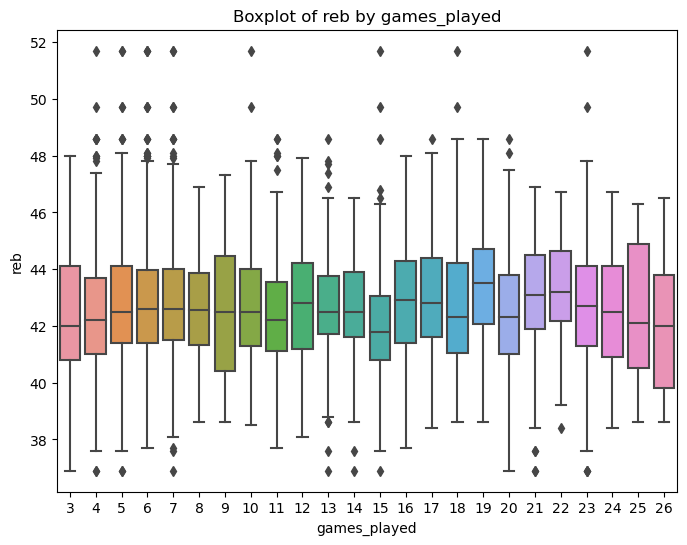

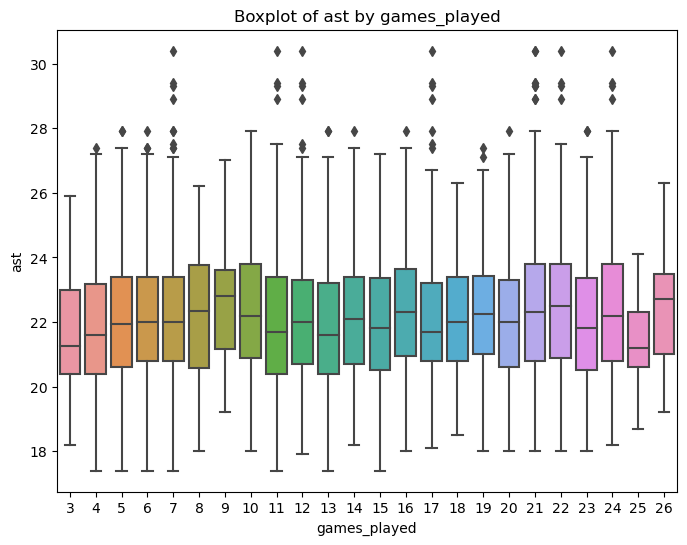

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for NaN values in 'games_played'
print(merged_df['games_played'].isnull().sum())

# Drop rows with NaN values in 'games_played'
merged_df = merged_df.dropna(subset=['games_played'])

# Convert 'games_played' to categorical
merged_df['games_played'] = pd.Categorical(merged_df['games_played'])

# Plot boxplots for each feature
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='games_played', y=feature, data=merged_df)
    plt.title(f'Boxplot of {feature} by games_played')
    plt.show()


### Split Data into Training and Testings Sets

In [ ]:
# Separate features and target variable
from sklearn.preprocessing import StandardScaler
X = merged_df[features]
y = merged_df['games_played']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




### Resampling

In [ ]:

# Separate features and target variable
X = merged_df[features]
y = merged_df['games_played']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Resampling using RandomOverSampler
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)




### Initialize LDA and Fit to Training Data

In [ ]:
def categorize_win_percentage(gp):
    if gp < 14:
        return 'Less than 14 games played.'
    else:
        return 'More than 14 games played.'

y_train_categorical = y_train.apply(categorize_win_percentage)
y_test_categorical = y_test.apply(categorize_win_percentage)


### Run LDA

In [ ]:
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train_categorical)
X_test_lda = lda.transform(X_test)


### Run Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_lda, y_train_categorical)
y_pred = clf.predict(X_test_lda)


In [ ]:
print("Classification Report:")
print(classification_report(y_test_categorical, y_pred))


Classification Report:
                            precision    recall  f1-score   support

Less than 14 games played.       0.77      0.86      0.81      1436
More than 14 games played.       0.69      0.55      0.61       826

                  accuracy                           0.75      2262
                 macro avg       0.73      0.70      0.71      2262
              weighted avg       0.74      0.75      0.74      2262



### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the base model
rf_base = RandomForestClassifier(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid,
                           cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_lda, y_train_categorical)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_tuned = best_rf_model.predict(X_test_lda)

# Print the classification report
print("Classification Report after Hyperparameter Tuning:")
print(classification_report(y_test_categorical, y_pred_tuned))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report after Hyperparameter Tuning:
                            precision    recall  f1-score   support

Less than 14 games played.       0.75      0.97      0.84      1436
More than 14 games played.       0.88      0.44      0.58       826

                  accuracy                           0.77      2262
                 macro avg       0.81      0.70      0.71      2262
              weighted avg       0.80      0.77      0.75      2262



### Test Set Predictions

In [ ]:
def predict_team_performance(team_name):
    # Extract the features for the specified team
    team_data = merged_df[merged_df['team'] == team_name][features]

    # Standardize the features
    team_data_scaled = scaler.transform(team_data)

    # Perform LDA transformation
    team_data_lda = lda.transform(team_data_scaled)

    # Make predictions using the trained model
    prediction = best_rf_model.predict(team_data_lda)

    # Print the prediction
    if prediction[0] == 'Less than 14 games played.':
        print(f"The model predicts that {team_name} will have less than 14 games played.")
    if prediction[0] == 'More than 14 games played.':
        print(f"The model predicts that {team_name} will have more than 14 games played.")


team_to_predict = "Los Angeles Lakers"  # Change this to the team you want to predict


predict_team_performance(team_to_predict)



The model predicts that Los Angeles Lakers will have less than 14 games played.
